In [42]:
import pandas as pd

weather = pd.read_csv("CLMMAXT_HKO_2.csv")


In [45]:
weather

,Year,Month,Day,TMAX
0,1884,1,1,15.3
1,1884,1,2,17.1
2,1884,1,3,19.6
3,1884,1,4,23.2
4,1884,1,5,19.4
...,...,...,...,...
48907,2024,11,26,23.4
48908,2024,11,27,21.5
48909,2024,11,28,21.5
48910,2024,11,29,21.2


In [47]:
weather.index = weather["Year"].apply(str) + "-" + weather["Month"].apply(str) + "-" + weather["Day"].apply(str)

In [48]:
weather.index

Index(['1884-1-1', '1884-1-2', '1884-1-3', '1884-1-4', '1884-1-5', '1884-1-6',
       '1884-1-7', '1884-1-8', '1884-1-9', '1884-1-10',
       ...
       '2024-11-21', '2024-11-22', '2024-11-23', '2024-11-24', '2024-11-25',
       '2024-11-26', '2024-11-27', '2024-11-28', '2024-11-29', '2024-11-30'],
      dtype='object', length=48912)

In [49]:
weather.index = pd.to_datetime(weather.index)

In [50]:
weather.index

DatetimeIndex(['1884-01-01', '1884-01-02', '1884-01-03', '1884-01-04',
               '1884-01-05', '1884-01-06', '1884-01-07', '1884-01-08',
               '1884-01-09', '1884-01-10',
               ...
               '2024-11-21', '2024-11-22', '2024-11-23', '2024-11-24',
               '2024-11-25', '2024-11-26', '2024-11-27', '2024-11-28',
               '2024-11-29', '2024-11-30'],
              dtype='datetime64[ns]', length=48912, freq=None)

In [51]:
weather.index.year

Index([1884, 1884, 1884, 1884, 1884, 1884, 1884, 1884, 1884, 1884,
       ...
       2024, 2024, 2024, 2024, 2024, 2024, 2024, 2024, 2024, 2024],
      dtype='int32', length=48912)

In [52]:
weather.index.day

Index([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10,
       ...
       21, 22, 23, 24, 25, 26, 27, 28, 29, 30],
      dtype='int32', length=48912)

In [53]:
weather.index.month

Index([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
       ...
       11, 11, 11, 11, 11, 11, 11, 11, 11, 11],
      dtype='int32', length=48912)

In [54]:
weather.index.year.value_counts().sort_index()

1884    366
1885    365
1886    365
1887    365
1888    366
       ... 
2020    366
2021    365
2022    365
2023    365
2024    335
Name: count, Length: 134, dtype: int64

<Axes: >

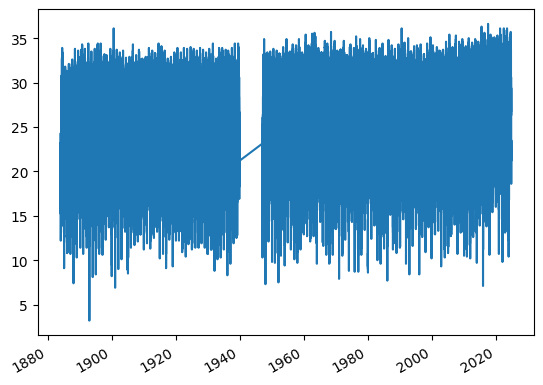

In [55]:
weather["TMAX"].plot()

<Axes: >

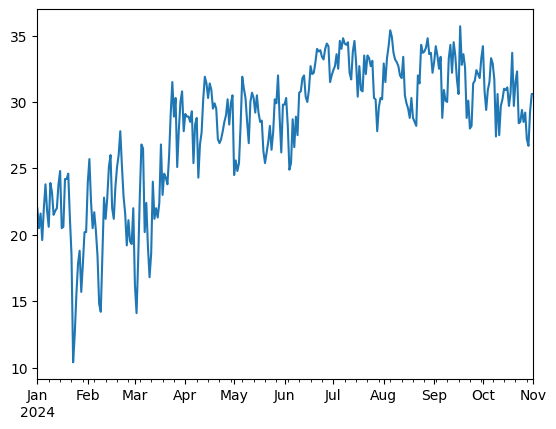

In [56]:
weather.loc["2024-01-01":"2024-11-01"]["TMAX"].plot()

In [57]:
weather["Target"] = weather.shift(-1)["TMAX"]

In [58]:
weather

,Year,Month,Day,TMAX,Target
1884-01-01,1884,1,1,15.3,17.1
1884-01-02,1884,1,2,17.1,19.6
1884-01-03,1884,1,3,19.6,23.2
1884-01-04,1884,1,4,23.2,19.4
1884-01-05,1884,1,5,19.4,18.7
...,...,...,...,...,...
2024-11-26,2024,11,26,23.4,21.5
2024-11-27,2024,11,27,21.5,21.5
2024-11-28,2024,11,28,21.5,21.2
2024-11-29,2024,11,29,21.2,22.0


In [59]:
weather = weather.ffill()

In [60]:
weather

,Year,Month,Day,TMAX,Target
1884-01-01,1884,1,1,15.3,17.1
1884-01-02,1884,1,2,17.1,19.6
1884-01-03,1884,1,3,19.6,23.2
1884-01-04,1884,1,4,23.2,19.4
1884-01-05,1884,1,5,19.4,18.7
...,...,...,...,...,...
2024-11-26,2024,11,26,23.4,21.5
2024-11-27,2024,11,27,21.5,21.5
2024-11-28,2024,11,28,21.5,21.2
2024-11-29,2024,11,29,21.2,22.0


In [64]:
from sklearn.linear_model import Ridge

rr = Ridge(alpha=.1)

In [65]:
predictors = weather.columns[~weather.columns.isin(["Target","Year","Month","Day"])]


In [66]:
predictors

Index(['TMAX'], dtype='object')

In [67]:
def backtest(weather, model, predictors, start=3650, step=90):
    all_predictions = []

    for i in range(start, weather.shape[0], step):
        train = weather.iloc[:i,:]
        test = weather.iloc[i:(i+step),:]
        
        model.fit(train[predictors], train["Target"])

        preds = model.predict(test[predictors])

        preds = pd.Series(preds, index=test.index)

        combined = pd.concat([test["Target"], preds], axis=1)
        
        combined.columns = ["Actual", "Prediction"]
        combined["Diff"] = (combined["Prediction"] - combined["Actual"]).abs()

        all_predictions.append(combined)
    return pd.concat(all_predictions)

In [68]:
predictions = backtest(weather, rr, predictors)

In [69]:
predictions

,Actual,Prediction,Diff
1893-12-29,15.7,16.868981,1.168981
1893-12-30,20.1,16.310974,3.789026
1893-12-31,23.2,20.403024,2.796976
1894-01-01,20.8,23.286059,2.486059
1894-01-02,17.8,21.054032,3.254032
...,...,...,...
2024-11-26,21.5,23.548401,2.048401
2024-11-27,21.5,21.787111,0.287111
2024-11-28,21.2,21.787111,0.587111
2024-11-29,22.0,21.509013,0.490987


In [70]:
from sklearn.metrics import mean_absolute_error

mean_absolute_error(predictions["Actual"],predictions["Prediction"])

1.535028100906419

In [71]:
predictions["Diff"].mean()

np.float64(1.535028100906419)

In [72]:
def pct_diff(old, new):
    return (new - old)/ old

def compute_rolling(weather, horizon, col):
    label = f"rolling_{horizon}_{col}"

    weather[label] = weather[col].rolling(horizon).mean()
    weather[f"{label}_pct"] = pct_diff(weather[label], weather[col])
    return weather

rolling_horizon = [3, 14]

for horizon in rolling_horizon:
    for col in ["TMAX"]:
        weather = compute_rolling(weather, horizon, col)

In [73]:
weather

,Year,Month,Day,TMAX,Target,rolling_3_TMAX,rolling_3_TMAX_pct,rolling_14_TMAX,rolling_14_TMAX_pct
1884-01-01,1884,1,1,15.3,17.1,NaN,NaN,NaN,NaN
1884-01-02,1884,1,2,17.1,19.6,NaN,NaN,NaN,NaN
1884-01-03,1884,1,3,19.6,23.2,17.333333,0.130769,NaN,NaN
1884-01-04,1884,1,4,23.2,19.4,19.966667,0.161937,NaN,NaN
1884-01-05,1884,1,5,19.4,18.7,20.733333,-0.064309,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2024-11-26,2024,11,26,23.4,21.5,23.300000,0.004292,23.885714,-0.020335
2024-11-27,2024,11,27,21.5,21.5,22.800000,-0.057018,23.550000,-0.087049
2024-11-28,2024,11,28,21.5,21.2,22.133333,-0.028614,23.257143,-0.075553
2024-11-29,2024,11,29,21.2,22.0,21.400000,-0.009346,22.978571,-0.077401


In [74]:
weather = weather.iloc[14:,:]

In [75]:
weather

,Year,Month,Day,TMAX,Target,rolling_3_TMAX,rolling_3_TMAX_pct,rolling_14_TMAX,rolling_14_TMAX_pct
1884-01-15,1884,1,15,18.2,19.3,19.833333,-0.082353,18.707143,-0.027110
1884-01-16,1884,1,16,19.3,18.9,19.166667,0.006957,18.864286,0.023097
1884-01-17,1884,1,17,18.9,17.8,18.800000,0.005319,18.814286,0.004556
1884-01-18,1884,1,18,17.8,17.6,18.666667,-0.046429,18.428571,-0.034109
1884-01-19,1884,1,19,17.6,16.8,18.100000,-0.027624,18.300000,-0.038251
...,...,...,...,...,...,...,...,...,...
2024-11-26,2024,11,26,23.4,21.5,23.300000,0.004292,23.885714,-0.020335
2024-11-27,2024,11,27,21.5,21.5,22.800000,-0.057018,23.550000,-0.087049
2024-11-28,2024,11,28,21.5,21.2,22.133333,-0.028614,23.257143,-0.075553
2024-11-29,2024,11,29,21.2,22.0,21.400000,-0.009346,22.978571,-0.077401


In [76]:
weather = weather.fillna(0)

In [77]:
weather

,Year,Month,Day,TMAX,Target,rolling_3_TMAX,rolling_3_TMAX_pct,rolling_14_TMAX,rolling_14_TMAX_pct
1884-01-15,1884,1,15,18.2,19.3,19.833333,-0.082353,18.707143,-0.027110
1884-01-16,1884,1,16,19.3,18.9,19.166667,0.006957,18.864286,0.023097
1884-01-17,1884,1,17,18.9,17.8,18.800000,0.005319,18.814286,0.004556
1884-01-18,1884,1,18,17.8,17.6,18.666667,-0.046429,18.428571,-0.034109
1884-01-19,1884,1,19,17.6,16.8,18.100000,-0.027624,18.300000,-0.038251
...,...,...,...,...,...,...,...,...,...
2024-11-26,2024,11,26,23.4,21.5,23.300000,0.004292,23.885714,-0.020335
2024-11-27,2024,11,27,21.5,21.5,22.800000,-0.057018,23.550000,-0.087049
2024-11-28,2024,11,28,21.5,21.2,22.133333,-0.028614,23.257143,-0.075553
2024-11-29,2024,11,29,21.2,22.0,21.400000,-0.009346,22.978571,-0.077401


In [78]:
def expand_mean(df):
    return df.expanding(1).mean()

for col in ["TMAX"]:
    weather[f"month_avg_{col}"] = weather[col].groupby(weather.index.month, group_keys=False).apply(expand_mean)
    weather[f"day_avg_{col}"] = weather[col].groupby(weather.index.day_of_year,group_keys=False).apply(expand_mean)

In [79]:
weather

,Year,Month,Day,TMAX,Target,rolling_3_TMAX,rolling_3_TMAX_pct,rolling_14_TMAX,rolling_14_TMAX_pct,month_avg_TMAX,day_avg_TMAX
1884-01-15,1884,1,15,18.2,19.3,19.833333,-0.082353,18.707143,-0.027110,18.200000,18.200000
1884-01-16,1884,1,16,19.3,18.9,19.166667,0.006957,18.864286,0.023097,18.750000,19.300000
1884-01-17,1884,1,17,18.9,17.8,18.800000,0.005319,18.814286,0.004556,18.800000,18.900000
1884-01-18,1884,1,18,17.8,17.6,18.666667,-0.046429,18.428571,-0.034109,18.550000,17.800000
1884-01-19,1884,1,19,17.6,16.8,18.100000,-0.027624,18.300000,-0.038251,18.360000,17.600000
...,...,...,...,...,...,...,...,...,...,...,...
2024-11-26,2024,11,26,23.4,21.5,23.300000,0.004292,23.885714,-0.020335,24.055553,22.697015
2024-11-27,2024,11,27,21.5,21.5,22.800000,-0.057018,23.550000,-0.087049,24.054917,22.330597
2024-11-28,2024,11,28,21.5,21.2,22.133333,-0.028614,23.257143,-0.075553,24.054281,22.032090
2024-11-29,2024,11,29,21.2,22.0,21.400000,-0.009346,22.978571,-0.077401,24.053571,21.670896


In [80]:
predictors = weather.columns[~weather.columns.isin(["Target","Year","Month","Day"])]


In [81]:
predictors

Index(['TMAX', 'rolling_3_TMAX', 'rolling_3_TMAX_pct', 'rolling_14_TMAX',
       'rolling_14_TMAX_pct', 'month_avg_TMAX', 'day_avg_TMAX'],
      dtype='object')

In [82]:
predictions = backtest(weather, rr, predictors)

In [83]:
mean_absolute_error(predictions["Actual"],predictions["Prediction"])

1.45431896591263

In [84]:
predictions.sort_values("Diff", ascending=False)

,Actual,Prediction,Diff
1987-11-28,11.2,24.827709,13.627709
1952-12-02,10.5,22.578772,12.078772
1948-01-24,9.6,20.441546,10.841546
1931-12-12,11.1,21.688396,10.588396
1969-04-04,13.5,23.874664,10.374664
...,...,...,...
1998-09-01,28.9,28.899678,0.000322
2012-07-23,29.2,29.200172,0.000172
2001-10-02,28.5,28.499859,0.000141
2023-04-20,25.3,25.299899,0.000101


In [85]:
weather.loc["1990-03-07":"1990-03-17"]

,Year,Month,Day,TMAX,Target,rolling_3_TMAX,rolling_3_TMAX_pct,rolling_14_TMAX,rolling_14_TMAX_pct,month_avg_TMAX,day_avg_TMAX
1990-03-07,1990,3,7,20.4,19.3,18.733333,0.088968,15.885714,0.284173,20.357835,19.521
1990-03-08,1990,3,8,19.3,19.4,19.233333,0.003466,15.771429,0.223732,20.357491,19.824
1990-03-09,1990,3,9,19.4,19.7,19.700000,-0.015228,15.678571,0.237358,20.357180,19.951
1990-03-10,1990,3,10,19.7,24.8,19.466667,0.011986,15.950000,0.235110,20.356967,20.096
1990-03-11,1990,3,11,24.8,24.0,21.300000,0.164319,16.807143,0.475563,20.358409,20.125
1990-03-12,1990,3,12,24.0,19.0,22.833333,0.051095,17.700000,0.355932,20.359591,20.448
1990-03-13,1990,3,13,19.0,22.4,22.600000,-0.159292,18.085714,0.050553,20.359150,20.265
1990-03-14,1990,3,14,22.4,24.1,21.800000,0.027523,18.642857,0.201533,20.359812,20.208
1990-03-15,1990,3,15,24.1,20.7,21.833333,0.103817,19.321429,0.247320,20.361025,20.095
1990-03-16,1990,3,16,20.7,21.9,22.400000,-0.075893,19.742857,0.048480,20.361135,20.145


<Axes: xlabel='Diff'>

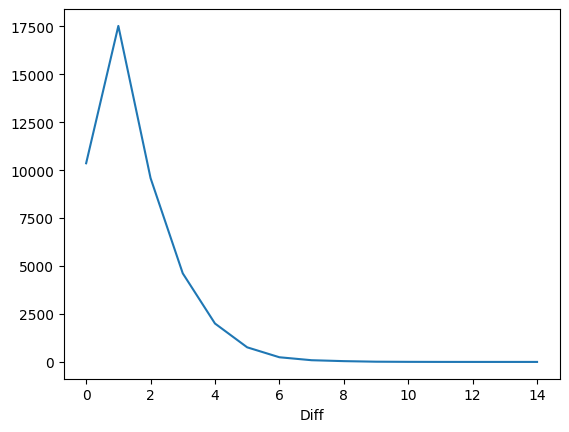

In [86]:
predictions["Diff"].round().value_counts().sort_index().plot()

In [87]:
weather

,Year,Month,Day,TMAX,Target,rolling_3_TMAX,rolling_3_TMAX_pct,rolling_14_TMAX,rolling_14_TMAX_pct,month_avg_TMAX,day_avg_TMAX
1884-01-15,1884,1,15,18.2,19.3,19.833333,-0.082353,18.707143,-0.027110,18.200000,18.200000
1884-01-16,1884,1,16,19.3,18.9,19.166667,0.006957,18.864286,0.023097,18.750000,19.300000
1884-01-17,1884,1,17,18.9,17.8,18.800000,0.005319,18.814286,0.004556,18.800000,18.900000
1884-01-18,1884,1,18,17.8,17.6,18.666667,-0.046429,18.428571,-0.034109,18.550000,17.800000
1884-01-19,1884,1,19,17.6,16.8,18.100000,-0.027624,18.300000,-0.038251,18.360000,17.600000
...,...,...,...,...,...,...,...,...,...,...,...
2024-11-26,2024,11,26,23.4,21.5,23.300000,0.004292,23.885714,-0.020335,24.055553,22.697015
2024-11-27,2024,11,27,21.5,21.5,22.800000,-0.057018,23.550000,-0.087049,24.054917,22.330597
2024-11-28,2024,11,28,21.5,21.2,22.133333,-0.028614,23.257143,-0.075553,24.054281,22.032090
2024-11-29,2024,11,29,21.2,22.0,21.400000,-0.009346,22.978571,-0.077401,24.053571,21.670896


In [93]:
predictions


,Actual,Prediction,Diff
1894-01-12,20.1,18.796900,1.303100
1894-01-13,18.2,19.422666,1.222666
1894-01-14,18.1,18.039029,0.060971
1894-01-15,18.8,17.834227,0.965773
1894-01-16,19.1,18.327262,0.772738
...,...,...,...
2024-11-26,21.5,23.501713,2.001713
2024-11-27,21.5,22.116559,0.616559
2024-11-28,21.2,22.074229,0.874229
2024-11-29,22.0,21.820243,0.179757


<Axes: >

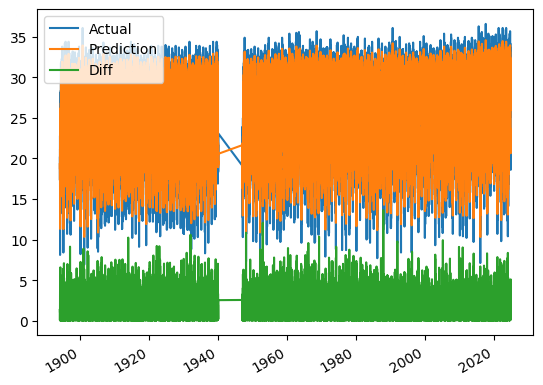

In [94]:
predictions.plot()

<Axes: >

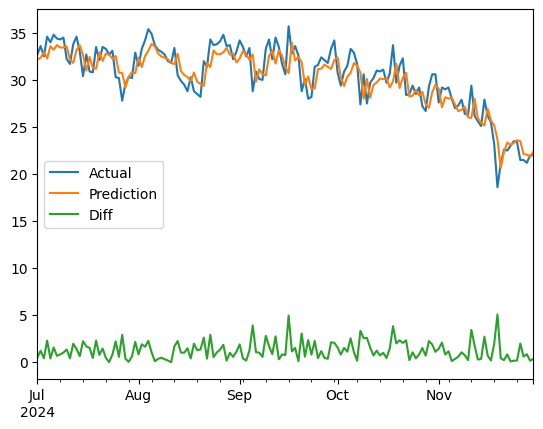

In [96]:
predictions.loc["2024-07-01":"2024-11-30"].plot()